In [1]:
import torch

### Load Analyzed Games

In [2]:
# position_type = "bitboards"         # 46.2% accuracy
# position_type = "bitboards_mirrors" # 45.7% accuracy
# position_type = "boards"            # 46.2% accuracy
position_type = "boards_mirrors"    # 46.7% accuracy

In [3]:
dataset_path = "../../datasets/analyzed_positions/"
positions, elo1 = torch.load(dataset_path + f"all_{position_type}.pt")
analysis, elo2 = torch.load(dataset_path + "all_analysis.pt")

positions = [positions[i:i+500] for i in range(0, 9500, 1000)]
positions = sum(positions, [])

for pos, anal in zip(positions, analysis):
    assert pos.size()[1] == anal.size()[1]

elo1 = [elo1[i:i+500] for i in range(0, 9500, 1000)]
elo1 = sum(elo1, [])

for e1, e2 in zip(elo1, elo2):
    assert e1[0] == e2[0] and e1[1] == e2[1]

In [4]:
# dataset is of the form [(white_analysis, black_analysis), (white_elo, black_elo)]
print(f"Number of games: {len(positions)}, {len(analysis)}, {len(elo1)}, {len(elo2)}")
print(f"Moves of first game: {len(positions[0][0])}")
print(f"Input size: {len(positions[0][0][0]) + len(analysis[0][0][0])}")

input_size = len(positions[0][0][0]) + len(analysis[0][0][0])

Number of games: 5000, 5000, 5000, 5000
Moves of first game: 59
Input size: 786


### Define the Model

In [5]:
import sys
sys.path.append("..")

from lstm_network import initialize_model

In [6]:
# Switch to GPU if available for faster calculations
if torch.cuda.is_available():
    device = torch.device("cuda")          # Use CUDA device
    print('Using GPU:', torch.cuda.get_device_name(0))
    torch.cuda.empty_cache()
else:
    device = torch.device("cpu") 

Using GPU: NVIDIA GeForce MX230


In [7]:
hidden_size = 128
num_layers = 2
learning_rate = 0.001
lstm_model, optimizer = initialize_model(input_size, hidden_size, num_layers, device, learning_rate)

### Modify the dataset for training

In [8]:
import random

dataset = [
    (torch.cat((game_position, game_analysis), dim=-1), game_elo) 
    for game_position, game_analysis, game_elo, elo_check in zip(positions, analysis, elo1, elo2) 
    if all(e1 == e2 for e1, e2 in zip(game_elo, elo_check)) and len(game_position) == len(game_analysis)
]

total_games = len(dataset)

# Spilt into train and test data
test_games = int(total_games * 0.15)

random.shuffle(dataset)

max_elo = 3000

x_train = [game.to(device) for game, _ in dataset[:-test_games]]
y_train = [elo.reshape((2, 1)).to(device)/max_elo for _, elo in dataset[:-test_games]]
x_test  = [game.to(device) for game, _ in dataset[-test_games:]]
y_test  = [elo.reshape((2, 1)).to(device)/max_elo for _, elo in dataset[-test_games:]]

### Train the model

In [9]:
from lstm_network import train_model

In [10]:
# MSE loss for single output prediction
loss_func = torch.nn.functional.mse_loss

loss_graph = train_model(lstm_model, optimizer, loss_func, (x_train, y_train), num_epochs=10)

Epoch: 1, Validation Loss: 0.02042228830483792
Epoch: 2, Validation Loss: 0.016795417155673013
Epoch: 3, Validation Loss: 0.015941677887038246
Epoch: 4, Validation Loss: 0.016149912390198667
Epoch: 5, Validation Loss: 0.016819686537824955
Epoch: 6, Validation Loss: 0.0174059765523371
Epoch: 7, Validation Loss: 0.016346708008076
Epoch: 8, Validation Loss: 0.016508441258231196
Epoch: 9, Validation Loss: 0.01649836505483828
Epoch: 10, Validation Loss: 0.016948834936977717


Text(0, 0.5, 'Loss')

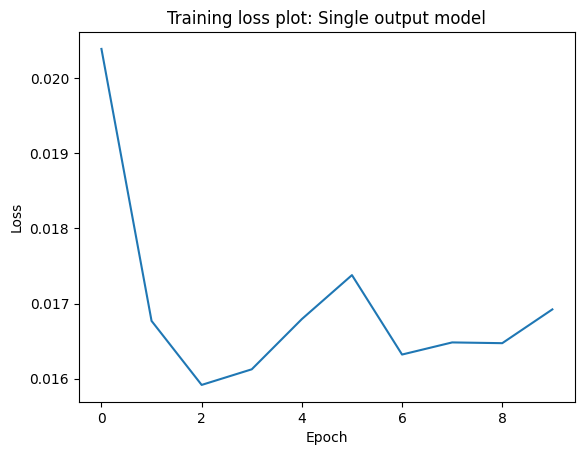

In [18]:
import matplotlib.pyplot as plt

# Visualize the loss as the network trained
# Should be a downward trend
plt.plot(loss_graph)
plt.title("Training loss plot: Single output model")
plt.xlabel("Epoch")
plt.ylabel("Loss")

### Test how the model predicts new data

The predictions of the model are compared to a random guessing and a constant guessing model

In [19]:
predictions = []
real_values = []

for x, y in zip(x_test, y_test):
    # Predict for white and black
    out = lstm_model(x[0], train=False)[0] # [0] to get rid of hidden states
    predictions.append(out[0].item() * max_elo)
    real_values.append(y[0].item() * max_elo)

    out = lstm_model(x[1], train=False)[0]
    
    predictions.append(out[0].item() * max_elo) # [0].item() to get rid of batch dimension and get the elo prediction
    real_values.append(y[1].item() * max_elo)

Text(0, 0.5, 'Real')

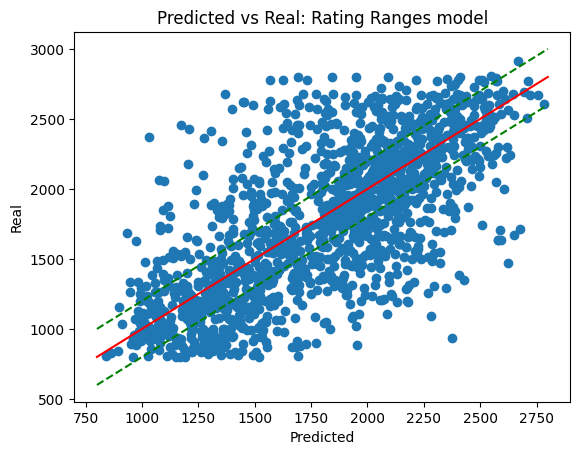

In [20]:
plt.plot(predictions, real_values, 'o')

plt.plot([800, 2800], [800, 2800], 'r-') # the closer to this line the better
plt.plot([800, 2800], [600, 2600], 'g--')
plt.plot([800, 2800], [1000, 3000], 'g--') # these two lines show acceptable error (200 elo)

plt.title("Predicted vs Real: Rating Ranges model")
plt.xlabel("Predicted")
plt.ylabel("Real")

In [21]:
def rate_predictions(predictions, real_values):
    correct = 0
    diff = 0
    high_elo = [0, 0]
    low_elo = [0, 0]
    real_high = 0
    real_low = 0
    # We give the model a leeway of +-200 points
    # More leeway = more accuracy
    leeway = 200
    for prediction, real in zip(predictions, real_values):
        if real - leeway <= prediction <= real + leeway:
            correct += 1
        diff += abs(prediction - real)
        if real > 1700:
            high_elo[0] += 1
            high_elo[1] += prediction
            real_high += real
        if real <= 1700:
            low_elo[0] += 1
            low_elo[1] += prediction
            real_low += real
    return correct / len(predictions), correct, diff/len(predictions), high_elo[1]/high_elo[0], low_elo[1]/low_elo[0], real_high/high_elo[0], real_low/low_elo[0]

percentage, correct, diff, high_predictions, low_predictions, real_high, real_low = rate_predictions(predictions, real_values)
print(f"Correctly predicted {percentage * 100:.2f}% of games")
print(f"{correct} out of {len(predictions)} predictions")
print(f"Average difference: {diff:.2f} elo")
print(f"Average prediction for high elo games: {high_predictions:.2f} elo. Real average: {real_high:.2f} elo")
print(f"Average prediction for low elo games: {low_predictions:.2f} elo. Real average: {real_low:.2f} elo")

Correctly predicted 46.20% of games
693 out of 1500 predictions
Average difference: 290.44 elo
Average prediction for high elo games: 2031.94 elo. Real average: 2186.63 elo
Average prediction for low elo games: 1511.34 elo. Real average: 1281.57 elo


In [22]:
import random

random_predictions = [random.randint(800, 3000) for _ in range(len(predictions))]
percentage, correct, diff, _, _, _, _ = rate_predictions(random_predictions, real_values)
print(f"Correctly guessed at random {percentage * 100:.2f}% of games")
print(f"{correct} out of {len(random_predictions)} predictions")  
print(f"Average difference: {diff:.2f} elo") 

Correctly guessed at random 19.07% of games
286 out of 1500 predictions
Average difference: 683.95 elo


In [23]:
constant_predictions = [(800 + 2800)//2 for _ in range(len(predictions))]
percentage, correct, diff, _, _, _, _  = rate_predictions(constant_predictions, real_values)
print(f"Correctly guessed with constant guess {percentage * 100:.2f}% of games")
print(f"{correct} out of {len(constant_predictions)} predictions")
print(f"Average difference: {diff:.2f} elo")

Correctly guessed with constant guess 22.33% of games
335 out of 1500 predictions
Average difference: 454.15 elo


In [24]:
# If the results are acceptable, save the model
torch.save(lstm_model.state_dict(), f"{position_type}.pt")